In [112]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as dsp

In [113]:
def plot_spec(signal,fs,tipo="full",win="rect"):
    espec=20*np.log10(np.abs(np.fft.fft(signal))/len(signal))
    espec=np.fft.fftshift(espec)
    fcia=np.linspace(-fs/2,fs/2,len(signal))
    if tipo=="half":
        espec=espec[len(signal)//2:]
        fcia=fcia[len(signal)//2:]
    plt.figure()
    plt.title('Espectro de la señal')
    plt.plot(fcia,espec)
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Amplitud [dB]')
    plt.grid()

<img src="generador.jpeg">
<img src="SDS00007.BMP">

In [114]:
data = np.genfromtxt("SDS00007.CSV", delimiter=",", skip_header=2)

### variables ###
fc=10e6

frecuencia de muestreo:  100000000.00059389


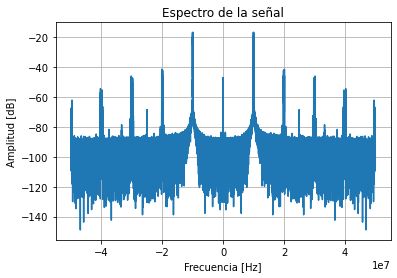

In [115]:
t=data[:,0]
v=data[:,1]

fs=1/(t[1]-t[0])

plot_spec(v,fs,tipo="full",win="rect")
print("frecuencia de muestreo: ",fs)

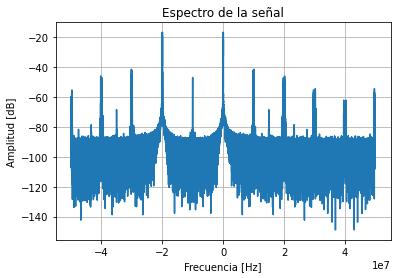

In [116]:
bb=v*np.exp(-1j*2*np.pi*fc*t)
plot_spec(bb,fs,tipo="full",win="rect")

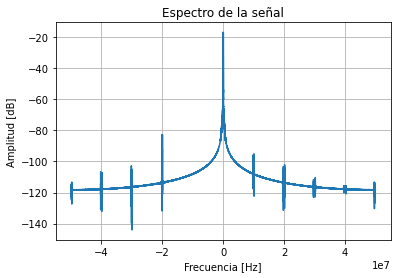

In [117]:
kernel=dsp.firwin(200,200e3/fs)
bb_filt=np.convolve(bb,kernel,mode='same')

plot_spec(bb_filt,fs,tipo="full",win="rect")
#plt.xlim(-250e3,250e3)

nueva frecuencia de muestreo:  666666.6666706259


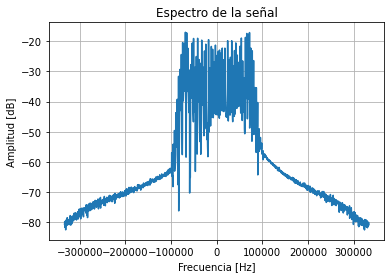

In [118]:
downsample_factor=150
bb_resample = dsp.resample_poly(bb_filt, up=1, down=downsample_factor, window=('kaiser', 8.6))
#bb_resample = bb_filt[::downsample_factor]

print("nueva frecuencia de muestreo: ",fs/downsample_factor)
t2=t[::downsample_factor]
plot_spec(bb_resample,fs/downsample_factor,tipo="full",win="rect")

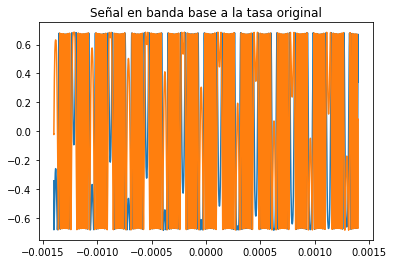

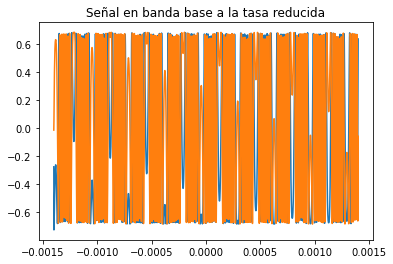

In [119]:
plt.figure()
plt.title('Señal en banda base a la tasa original')    
plt.plot(t,np.real(bb_filt),t,np.imag(bb_filt))
plt.figure()
plt.title('Señal en banda base a la tasa reducida')
plt.plot(t2,np.real(bb_resample),t2,np.imag(bb_resample))


In [120]:
def FM_demod (señal,fs):
    return np.angle(señal[:-1]*np.conjugate(señal[1:]))*fs/(2*np.pi)


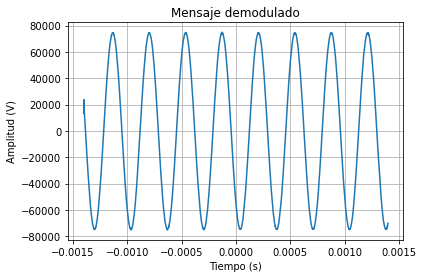

In [121]:
msj=FM_demod(bb_resample,fs/downsample_factor)
plt.figure()
plt.plot(t2[:-1],msj)
plt.title('Mensaje demodulado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (V)')
plt.grid()
plt.show()

In [122]:
print("desviacion maxima {} Hz".format(np.max((msj))))
print("desviacion minima {} Hz".format(np.min((msj))))
### Estimación del error de frecuencia
fo=(np.max((msj))+np.min((msj)))/2  # fo frequency offset 
print("error de frecuencia {} Hz".format(fo))


desviacion maxima 74996.43658742303 Hz
desviacion minima -75132.59561265373 Hz
error de frecuencia -68.07951261535345 Hz


## Corrección del error de frecuencia


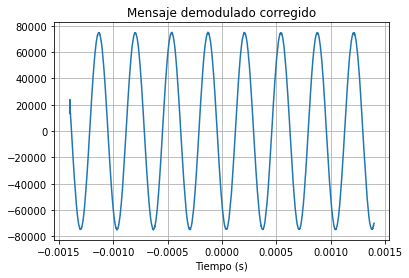

In [123]:
bb_corrected=v*np.exp(-1j*2*np.pi*(fc-fo)*t)
bb_corrected=np.convolve(bb_corrected,kernel,mode='same')
bb_corrected = dsp.resample_poly(bb_corrected, up=1, down=downsample_factor, window=('kaiser', 8.6))
#bb_corrected = bb_corrected[::downsample_factor]   
msj_corrected=FM_demod(bb_corrected,fs/downsample_factor)
plt.figure()
plt.plot(t2[:-1],msj_corrected)
plt.title('Mensaje demodulado corregido')
plt.xlabel('Tiempo (s)')
plt.grid()    

In [124]:
print("desviacion maxima {} Hz".format(np.round(np.max((msj_corrected)),2)))
print("desviacion minima {} Hz".format(np.round(np.min((msj_corrected)),2)))

fo=(np.max((msj_corrected))+np.min((msj_corrected)))/2  # fo frequency offset 
print("error de frecuencia {} Hz".format(np.round(fo, 2)))

desviacion maxima 75064.48 Hz
desviacion minima -75064.45 Hz
error de frecuencia 0.01 Hz


<img src="analizador.jpeg">

# sin downsampling

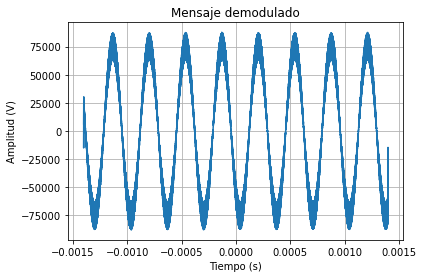

In [125]:
msj=FM_demod(bb_filt,fs)
plt.figure()
plt.plot(t[:-1],msj)
plt.title('Mensaje demodulado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (V)')
plt.grid()
plt.show()

In [126]:
lpf=dsp.firwin(251,15e3/fs)
msj_filt=np.convolve(msj,lpf,mode='same')   

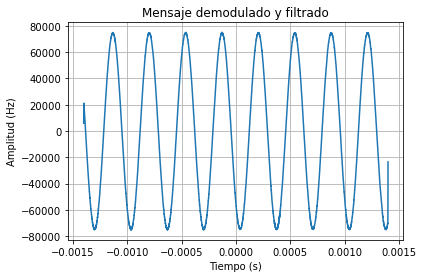

In [127]:
plt.plot(t[:-1],msj_filt)
plt.title('Mensaje demodulado y filtrado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (Hz)')
plt.grid()
plt.show()

In [130]:
print("desviacion maxima {} Hz".format(np.max((msj_filt))))
print("desviacion minima {} Hz".format(np.min((msj_filt))))
### Estimación del error de frecuencia
fo=(np.max((msj_filt))+np.min((msj_filt)))/2  # fo frequency offset
print("error de frecuencia {} Hz".format(np.round(fo, 2)))


desviacion maxima 75115.76697599508 Hz
desviacion minima -75248.46360499723 Hz
error de frecuencia -66.35 Hz


## Correccion del error de frecuencia

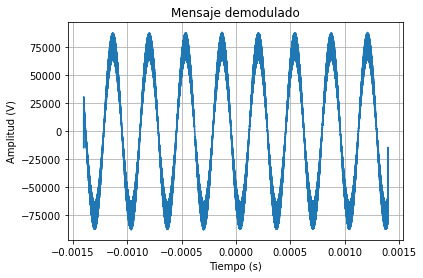

In [132]:
bb_corrected=v*np.exp(-1j*2*np.pi*(fc-fo)*t)
bb_corrected=np.convolve(bb_corrected,kernel,mode='same')
msj=FM_demod(bb_corrected,fs)
plt.figure()
plt.plot(t[:-1],msj)
plt.title('Mensaje demodulado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (V)')
plt.grid()
plt.show()

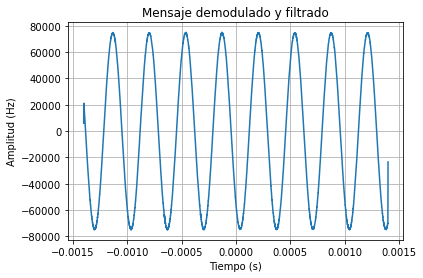

In [135]:
msj_filt=np.convolve(msj,lpf,mode='same')
plt.plot(t[:-1],msj_filt)
plt.title('Mensaje demodulado y filtrado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud (Hz)')
plt.grid()
plt.show()

In [136]:
print("desviacion maxima {} Hz".format(np.max((msj_filt))))
print("desviacion minima {} Hz".format(np.min((msj_filt))))
### Estimación del error de frecuencia
fo=(np.max((msj_filt))+np.min((msj_filt)))/2  # fo frequency offset
print("error de frecuencia {} Hz".format(np.round(fo, 2)))

desviacion maxima 75182.14587741892 Hz
desviacion minima -75182.09390925935 Hz
error de frecuencia 0.03 Hz
